# Import libraries

In [0]:
from pyspark.sql.functions import col, when, count, isnan, sum
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt

# ML models that will be used 
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier,
    DecisionTreeClassifier,
    NaiveBayes
)

from pyspark.ml.evaluation import BinaryClassificationEvaluator  


# Load dataset

In [0]:
df = spark.read.table("thyroid_cancer_risk_only")


## Initial Exploration


In [0]:
# Drop Patient_ID as its a unique identifier 
df = df.drop("Patient_ID")

In [0]:
print("Number of records:", df.count())
print("\nSchema:")
df.printSchema()
pd.DataFrame(df.take(10), columns=df.columns).transpose()

Number of records: 212691

Schema:
root
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Family_History: string (nullable = true)
 |-- Radiation_Exposure: string (nullable = true)
 |-- Iodine_Deficiency: string (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Obesity: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Thyroid_Cancer_Risk: string (nullable = true)



,0,1,2,3,4,5,6,7,8,9
Age,66,29,86,75,35,89,89,38,17,36
Gender,Male,Male,Male,Female,Female,Male,Female,Female,Female,Male
Country,Russia,Germany,Nigeria,India,Germany,UK,South Korea,India,Russia,Germany
Ethnicity,Caucasian,Hispanic,Caucasian,Asian,African,African,Asian,African,African,Asian
Family_History,No,No,No,No,Yes,No,Yes,No,No,No
Radiation_Exposure,Yes,Yes,No,No,Yes,No,Yes,No,Yes,No
Iodine_Deficiency,No,No,No,No,No,No,No,No,No,No
Smoking,No,No,No,No,No,Yes,No,No,No,No
Obesity,No,No,No,No,No,Yes,Yes,No,No,Yes
Diabetes,No,No,No,No,No,No,No,No,Yes,No


## Check Correlation between features

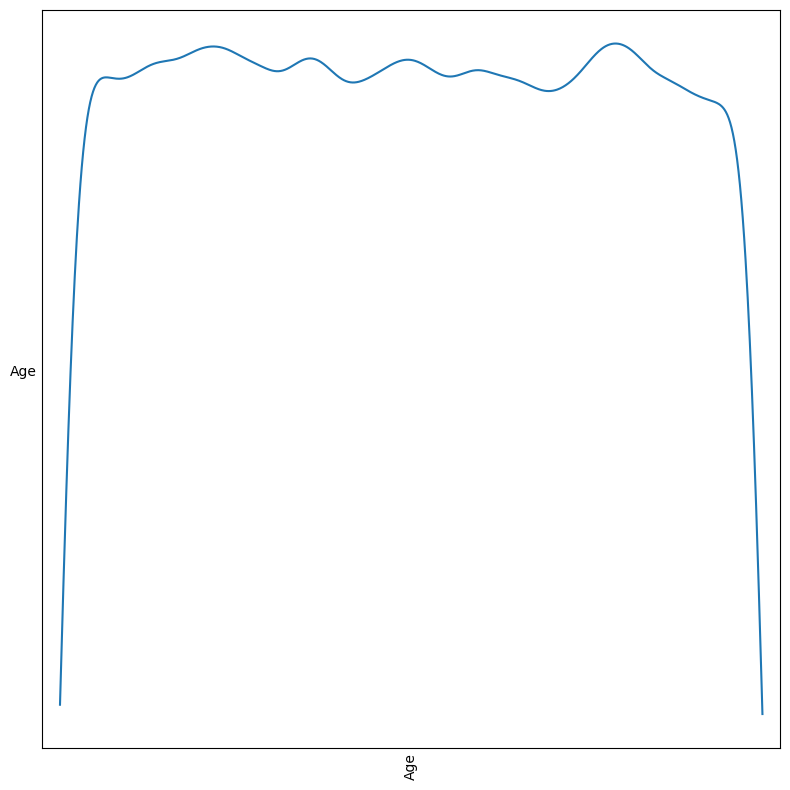

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define your numeric features
numeric_features = ["Age"] 

# Step 2: Convert numeric data to Pandas
numeric_data = df.select(numeric_features).toPandas()

# Step 3: Create the scatter matrix plot
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8), diagonal='kde')

# Step 4: Optional adjustments to make axes/labels cleaner
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())

    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# Step 5: Show the plot
plt.tight_layout()
plt.show()


# Feature Engineering and Preprocessing

In [0]:
# Defining Features
categorical_cols = ["Gender", "Country", "Ethnicity", "Family_History", 
                    "Radiation_Exposure", "Iodine_Deficiency", 
                    "Smoking", "Obesity", "Diabetes"]
numerical_cols = ["Age"]

# Index all categorical features
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") 
    for col in categorical_cols
]

# Assemble features (indexed categoricals + numeric)
assembler = VectorAssembler(
    inputCols=[col + "_idx" for col in categorical_cols] + numerical_cols,
    outputCol="features"
)

# Scale numeric feature(s)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Index the label (multiclass target)
label_indexer = StringIndexer(
    inputCol="Thyroid_Cancer_Risk", 
    outputCol="label", 
    handleInvalid="keep"
)

# Combine all preprocessing stages into one list
base_stages = indexers + [assembler, scaler, label_indexer]


### Modular Preprocessing 
Modular because we're using multiple models

In [0]:
# Preprocessing stages (no model here yet)
preprocessing_stages = indexers + [assembler, scaler, label_indexer]
preprocessing_pipeline = Pipeline(stages=preprocessing_stages)

# Fit and transform data once
preprocessed_model = preprocessing_pipeline.fit(df)
processed_df = preprocessed_model.transform(df)


# Logistic Regression / Multiclassification

In [0]:
# 1. Redefine or reuse preprocessing pipeline
base_stages = indexers + [assembler, scaler, label_indexer]

# 2. Create the logistic regression model
lr = LogisticRegression(
    featuresCol="scaled_features",
    labelCol="label",
    maxIter=10,
    regParam=0.1,
    elasticNetParam=0.0
)

# 3. Build the full pipeline
lr_pipeline = Pipeline(stages=base_stages + [lr])

# 4. Split raw data (df) before pipeline
lr_train_df, lr_test_df = df.randomSplit([0.7, 0.3], seed=42)

# 5. Fit the model
lr_model = lr_pipeline.fit(lr_train_df)

# 6. Make predictions
lr_predictions = lr_model.transform(lr_test_df)

print("✅ Logistic Regression model trained!")


✅ Logistic Regression model trained!


## Evaluating the model

In [0]:
# Use the model's predictions
predictions = lr_predictions  # Rename if needed for other models

# Initialize evaluator once
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Overall Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"✅ Accuracy: {accuracy:.3f}")

# Class labels (0 = Low, 1 = Medium, 2 = High)
labels = [0, 1, 2]

print("\n🔍 Per-Class Metrics:")
for label in labels:
    precision = evaluator.evaluate(predictions, {
        evaluator.metricName: "precisionByLabel",
        evaluator.metricLabel: label
    })
    recall = evaluator.evaluate(predictions, {
        evaluator.metricName: "recallByLabel",
        evaluator.metricLabel: label
    })
    f1 = evaluator.evaluate(predictions, {
        evaluator.metricName: "fMeasureByLabel",
        evaluator.metricLabel: label
    })
    
    print(f"Class {label}:")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall:    {recall:.3f}")
    print(f"\tF1 Score:  {f1:.3f}")

print("\n📊 Weighted Overall Metrics:")
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weighted_f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall:    {weighted_recall:.3f}")
print(f"Weighted F1 Score:  {weighted_f1:.3f}")


✅ Accuracy: 0.531

🔍 Per-Class Metrics:
Class 0:
	Precision: 0.529
	Recall:    0.966
	F1 Score:  0.684
Class 1:
	Precision: 0.000
	Recall:    0.000
	F1 Score:  0.000
Class 2:
	Precision: 0.548
	Recall:    0.235
	F1 Score:  0.329

📊 Weighted Overall Metrics:
Weighted Precision: 0.354
Weighted Recall:    0.531
Weighted F1 Score:  0.400


### Confusion Matrix

Class 0:
- Correctly predicted: 31,590
- Incorrectly predicted: 1,116 as class 2.0  

Class 1: 
- Incorrectly predicted: 20,761 as Class 0 & 740 as Class 1
- The model fails to predict Class 1  

Class 2: 
- Correctly predicted: 2,249
- Incorrectly predicted: 7,326 as Class 0 

In [0]:
print("\n🧾 Confusion Matrix:")
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()



🧾 Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|31590|
|  0.0|       2.0| 1116|
|  1.0|       0.0|20761|
|  1.0|       2.0|  740|
|  2.0|       0.0| 7326|
|  2.0|       2.0| 2249|
+-----+----------+-----+



### Check: Proper grouping

In [0]:
df.groupBy("Thyroid_Cancer_Risk").count().show()

+-------------------+------+
|Thyroid_Cancer_Risk| count|
+-------------------+------+
|               High| 31903|
|                Low|108388|
|             Medium| 72400|
+-------------------+------+



### Check: Proper Coding

In [0]:
# Check how StringIndexer mapped your risk labels
indexer = StringIndexer(inputCol="Thyroid_Cancer_Risk", outputCol="Thyroid_Cancer_Risk_Idx")
model = indexer.fit(df)

print("Label mapping (most frequent = 0):")
for label, idx in zip(model.labels, range(len(model.labels))):
    print(f"{idx}: {label}")


Label mapping (most frequent = 0):
0: Low
1: Medium
2: High


# Random forest classifier

In [0]:
# Step 1: Split raw data BEFORE the pipeline
rf_train_df, rf_test_df = df.randomSplit([0.7, 0.3], seed=42)

# Step 2: Define Random Forest model
rf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="label",
    numTrees=100,
    maxDepth=5,
    seed=42
)

# Step 3: Create pipeline with preprocessing + model
rf_pipeline = Pipeline(stages=base_stages + [rf])

# Step 4: Fit pipeline and make predictions
rf_model = rf_pipeline.fit(rf_train_df)
rf_predictions = rf_model.transform(rf_test_df)

print("✅ Random Forest model trained!")


✅ Random Forest model trained!


## Evaluating the model

In [0]:
# Use RF predictions
predictions = rf_predictions

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Overall Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"✅ Accuracy: {accuracy:.3f}")

# Class labels (0 = Low, 1 = Medium, 2 = High)
labels = [0, 1, 2]

print("\n🔍 Per-Class Metrics:")
for label in labels:
    precision = evaluator.evaluate(predictions, {
        evaluator.metricName: "precisionByLabel",
        evaluator.metricLabel: label
    })
    recall = evaluator.evaluate(predictions, {
        evaluator.metricName: "recallByLabel",
        evaluator.metricLabel: label
    })
    f1 = evaluator.evaluate(predictions, {
        evaluator.metricName: "fMeasureByLabel",
        evaluator.metricLabel: label
    })
    
    print(f"Class {label}:")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall:    {recall:.3f}")
    print(f"\tF1 Score:  {f1:.3f}")

# Weighted overall metrics
print("\n📊 Weighted Overall Metrics:")
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weighted_f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall:    {weighted_recall:.3f}")
print(f"Weighted F1 Score:  {weighted_f1:.3f}")


✅ Accuracy: 0.656

🔍 Per-Class Metrics:
Class 0:
	Precision: 0.598
	Recall:    1.000
	F1 Score:  0.749
Class 1:
	Precision: 0.000
	Recall:    0.000
	F1 Score:  0.000
Class 2:
	Precision: 1.000
	Recall:    0.952
	F1 Score:  0.975

📊 Weighted Overall Metrics:
Weighted Precision: 0.457
Weighted Recall:    0.656
Weighted F1 Score:  0.530


### Confusion Matrix


In [0]:
print("\n🧾 Confusion Matrix:")
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()



🧾 Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|32706|
|  1.0|       0.0|21501|
|  2.0|       0.0|  464|
|  2.0|       2.0| 9111|
+-----+----------+-----+



# Multilayer Perceptron Classifier (Neural Network)

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline

# Determine input size
num_input_features = len(assembler.getInputCols())

# Define MLP architecture
layers = [num_input_features, 5, 4, 3]

# Define model
mlp = MultilayerPerceptronClassifier(
    featuresCol="scaled_features",
    labelCol="label",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=123
)

# Create pipeline (assuming no encoder)
mlp_pipeline = Pipeline(stages=indexers + [assembler, scaler, label_indexer, mlp])

# Train-test split on raw data
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# ✅ Rename 'model' to 'mlp_model' for consistency
mlp_model = mlp_pipeline.fit(train_df)
mlp_predictions = mlp_model.transform(test_df)

print("✅ Multilayer Perceptron model trained!")


✅ Multilayer Perceptron model trained!


## Evaluating the model

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Use MLP predictions
predictions = mlp_predictions

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Overall Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"✅ Accuracy: {accuracy:.3f}")

# Class labels (0 = Low, 1 = Medium, 2 = High)
labels = [0, 1, 2]

print("\n🔍 Per-Class Metrics:")
for label in labels:
    precision = evaluator.evaluate(predictions, {
        evaluator.metricName: "precisionByLabel",
        evaluator.metricLabel: label
    })
    recall = evaluator.evaluate(predictions, {
        evaluator.metricName: "recallByLabel",
        evaluator.metricLabel: label
    })
    f1 = evaluator.evaluate(predictions, {
        evaluator.metricName: "fMeasureByLabel",
        evaluator.metricLabel: label
    })
    
    print(f"Class {label}:")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall:    {recall:.3f}")
    print(f"\tF1 Score:  {f1:.3f}")

# Weighted overall metrics
print("\n📊 Weighted Overall Metrics:")
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weighted_f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall:    {weighted_recall:.3f}")
print(f"Weighted F1 Score:  {weighted_f1:.3f}")


✅ Accuracy: 0.659

🔍 Per-Class Metrics:
Class 0:
	Precision: 0.603
	Recall:    0.992
	F1 Score:  0.750
Class 1:
	Precision: 0.000
	Recall:    0.000
	F1 Score:  0.000
Class 2:
	Precision: 0.958
	Recall:    1.000
	F1 Score:  0.978

📊 Weighted Overall Metrics:
Weighted Precision: 0.453
Weighted Recall:    0.659
Weighted F1 Score:  0.531


# Comparing Code LR, RF, and MLP

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

# Function to evaluate any set of predictions
def evaluate_model(predictions, model_name):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    results = {
        "Model": model_name,
        "Accuracy": evaluator.setMetricName("accuracy").evaluate(predictions),
        "Weighted Precision": evaluator.setMetricName("weightedPrecision").evaluate(predictions),
        "Weighted Recall": evaluator.setMetricName("weightedRecall").evaluate(predictions),
        "Weighted F1 Score": evaluator.setMetricName("weightedFMeasure").evaluate(predictions),
    }

    # Per-class metrics
    for label in [0, 1, 2]:
        results[f"Class {label} Precision"] = evaluator.evaluate(predictions, {
            evaluator.metricName: "precisionByLabel",
            evaluator.metricLabel: label
        })
        results[f"Class {label} Recall"] = evaluator.evaluate(predictions, {
            evaluator.metricName: "recallByLabel",
            evaluator.metricLabel: label
        })
        results[f"Class {label} F1 Score"] = evaluator.evaluate(predictions, {
            evaluator.metricName: "fMeasureByLabel",
            evaluator.metricLabel: label
        })

    return results

# Run evaluations for all models
lr_results = evaluate_model(lr_predictions, "Logistic Regression")
rf_results = evaluate_model(rf_predictions, "Random Forest")
mlp_results = evaluate_model(mlp_predictions, "Multilayer Perceptron")

# Create comparison table
comparison_df = pd.DataFrame([lr_results, rf_results, mlp_results])
comparison_df = comparison_df.set_index("Model")  # Make model names row index
comparison_df = comparison_df.round(3)  # Round for readability

# Display
comparison_df.T  # Transpose for vertical view


Model,Logistic Regression,Random Forest,Multilayer Perceptron
Accuracy,0.531,0.656,0.659
Weighted Precision,0.354,0.457,0.453
Weighted Recall,0.531,0.656,0.659
Weighted F1 Score,0.400,0.530,0.531
Class 0 Precision,0.529,0.598,0.603
Class 0 Recall,0.966,1.000,0.992
Class 0 F1 Score,0.684,0.749,0.750
Class 1 Precision,0.000,0.000,0.000
Class 1 Recall,0.000,0.000,0.000
Class 1 F1 Score,0.000,0.000,0.000


## Visualization

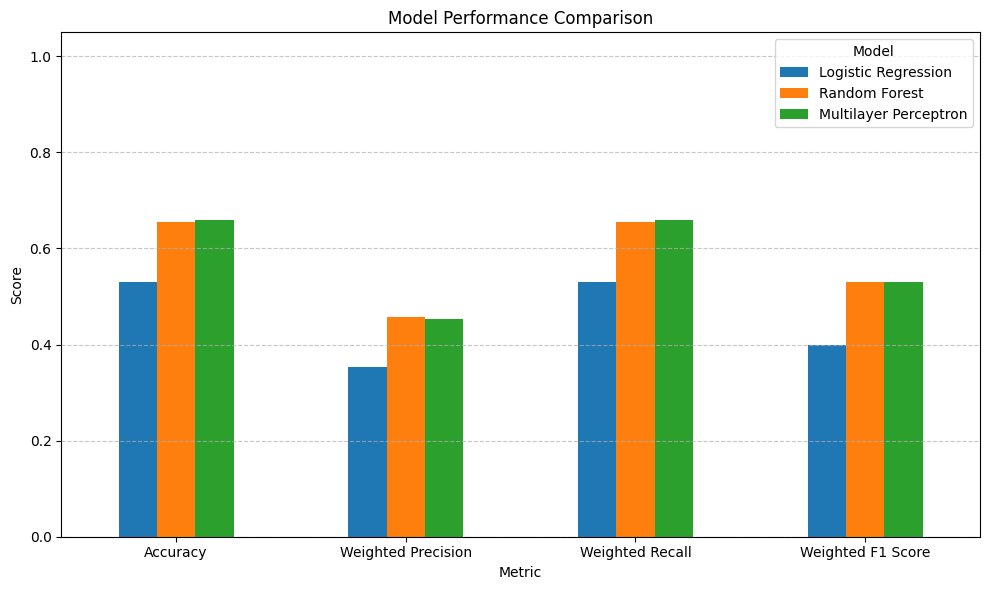

In [0]:
import matplotlib.pyplot as plt

# Pick the metrics you want to visualize
metrics_to_plot = [
    "Accuracy",
    "Weighted Precision",
    "Weighted Recall",
    "Weighted F1 Score"
]

# Subset the comparison DataFrame
plot_df = comparison_df[metrics_to_plot]

# Transpose so we can plot each model as a group
plot_df.T.plot(kind="bar", figsize=(10, 6), rot=0)

# Add labels and title
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1.05)  # Metrics are all between 0 and 1
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# Class balancing

In [0]:
from pyspark.sql import functions as F

# Check distribution (optional)
df.groupBy("Thyroid_Cancer_Risk").count().orderBy("count").show()

# Split by class
df_low = df.filter(df.Thyroid_Cancer_Risk == "Low")
df_med = df.filter(df.Thyroid_Cancer_Risk == "Medium")
df_high = df.filter(df.Thyroid_Cancer_Risk == "High")

# Oversample the minority class ("Medium")
target_size = max(df_low.count(), df_high.count())
df_med_oversampled = df_med.sample(withReplacement=True, fraction=(target_size / df_med.count()), seed=42)

# Combine and shuffle
balanced_df = df_low.union(df_high).union(df_med_oversampled)
balanced_df = balanced_df.orderBy(F.rand(seed=42))

print("✅ Balanced dataset created!")


+-------------------+------+
|Thyroid_Cancer_Risk| count|
+-------------------+------+
|               High| 31903|
|             Medium| 72400|
|                Low|108388|
+-------------------+------+

✅ Balanced dataset created!


### View new balance

In [0]:
balanced_df.groupBy("Thyroid_Cancer_Risk").count().orderBy("Thyroid_Cancer_Risk").show()


+-------------------+------+
|Thyroid_Cancer_Risk| count|
+-------------------+------+
|               High| 31903|
|                Low|108388|
|             Medium|107930|
+-------------------+------+



## Split the balanced dataset

In [0]:
# Use new variable names to preserve the original
balanced_train_df, balanced_test_df = balanced_df.randomSplit([0.7, 0.3], seed=42)


# Random Forest - balanced

## Train random forest

In [0]:
# Re-train Random Forest using the balanced dataset
rf_model_balanced = rf_pipeline.fit(balanced_train_df)

# Make predictions on the balanced test set
rf_predictions_balanced = rf_model_balanced.transform(balanced_test_df)

print("✅ Random Forest model retrained on balanced data!")


✅ Random Forest model retrained on balanced data!


## Evaluate model

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Set predictions to balanced Random Forest output
predictions = rf_predictions_balanced

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# ✅ Overall Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"✅ Accuracy: {accuracy:.3f}")

# ✅ Per-Class Metrics
labels = [0, 1, 2]  # Assuming 0 = Low, 1 = Medium, 2 = High

print("\n🔍 Per-Class Metrics:")
for label in labels:
    precision = evaluator.evaluate(predictions, {
        evaluator.metricName: "precisionByLabel",
        evaluator.metricLabel: label
    })
    recall = evaluator.evaluate(predictions, {
        evaluator.metricName: "recallByLabel",
        evaluator.metricLabel: label
    })
    f1 = evaluator.evaluate(predictions, {
        evaluator.metricName: "fMeasureByLabel",
        evaluator.metricLabel: label
    })

    print(f"Class {label}:")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall:    {recall:.3f}")
    print(f"\tF1 Score:  {f1:.3f}")

# ✅ Weighted Overall Metrics
print("\n📊 Weighted Overall Metrics:")
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weighted_f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall:    {weighted_recall:.3f}")
print(f"Weighted F1 Score:  {weighted_f1:.3f}")


✅ Accuracy: 0.576

🔍 Per-Class Metrics:
Class 0:
	Precision: 0.513
	Recall:    0.631
	F1 Score:  0.568
Class 1:
	Precision: 0.517
	Recall:    0.396
	F1 Score:  0.447
Class 2:
	Precision: 1.000
	Recall:    1.000
	F1 Score:  1.000

📊 Weighted Overall Metrics:
Weighted Precision: 0.574
Weighted Recall:    0.575
Weighted F1 Score:  0.565


# Logistic Regression - balanced

## Train logistic regresstion

In [0]:
# Train logistic regression on the balanced data
lr_model_balanced = lr_pipeline.fit(balanced_train_df)

# Make predictions
lr_predictions_balanced = lr_model_balanced.transform(balanced_test_df)

print("✅ Logistic Regression retrained on balanced dataset!")


✅ Logistic Regression retrained on balanced dataset!


## Evaluate model

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate using balanced predictions
predictions = lr_predictions_balanced

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Overall Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"✅ Accuracy: {accuracy:.3f}")

# Per-class metrics
labels = [0, 1, 2]

print("\n🔍 Per-Class Metrics:")
for label in labels:
    precision = evaluator.evaluate(predictions, {
        evaluator.metricName: "precisionByLabel",
        evaluator.metricLabel: label
    })
    recall = evaluator.evaluate(predictions, {
        evaluator.metricName: "recallByLabel",
        evaluator.metricLabel: label
    })
    f1 = evaluator.evaluate(predictions, {
        evaluator.metricName: "fMeasureByLabel",
        evaluator.metricLabel: label
    })

    print(f"Class {label}:")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall:    {recall:.3f}")
    print(f"\tF1 Score:  {f1:.3f}")

# Weighted metrics
print("\n📊 Weighted Overall Metrics:")
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weighted_f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall:    {weighted_recall:.3f}")
print(f"Weighted F1 Score:  {weighted_f1:.3f}")


✅ Accuracy: 0.451

🔍 Per-Class Metrics:
Class 0:
	Precision: 0.441
	Recall:    0.721
	F1 Score:  0.547
Class 1:
	Precision: 0.479
	Recall:    0.254
	F1 Score:  0.330
Class 2:
	Precision: 0.531
	Recall:    0.221
	F1 Score:  0.303

📊 Weighted Overall Metrics:
Weighted Precision: 0.467
Weighted Recall:    0.452
Weighted F1 Score:  0.424


# Multilayer Perceptron Classifier - balanced

In [0]:
mlp_pipeline = Pipeline(stages=indexers + [assembler, scaler, label_indexer, mlp])


In [0]:
# Train MLP on balanced data
mlp_model_balanced = mlp_pipeline.fit(balanced_train_df)

# Make predictions
mlp_predictions_balanced = mlp_model_balanced.transform(balanced_test_df)

print("✅ Multilayer Perceptron retrained on balanced dataset!")


✅ Multilayer Perceptron retrained on balanced dataset!


## Evaluate model

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Set predictions to balanced MLP output
predictions = mlp_predictions_balanced

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# ✅ Overall Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"✅ Accuracy: {accuracy:.3f}")

# ✅ Per-Class Metrics
labels = [0, 1, 2]

print("\n🔍 Per-Class Metrics:")
for label in labels:
    precision = evaluator.evaluate(predictions, {
        evaluator.metricName: "precisionByLabel",
        evaluator.metricLabel: label
    })
    recall = evaluator.evaluate(predictions, {
        evaluator.metricName: "recallByLabel",
        evaluator.metricLabel: label
    })
    f1 = evaluator.evaluate(predictions, {
        evaluator.metricName: "fMeasureByLabel",
        evaluator.metricLabel: label
    })

    print(f"Class {label}:")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall:    {recall:.3f}")
    print(f"\tF1 Score:  {f1:.3f}")

# ✅ Weighted Overall Metrics
print("\n📊 Weighted Overall Metrics:")
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
weighted_f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})

print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall:    {weighted_recall:.3f}")
print(f"Weighted F1 Score:  {weighted_f1:.3f}")


✅ Accuracy: 0.564

🔍 Per-Class Metrics:
Class 0:
	Precision: 0.498
	Recall:    0.654
	F1 Score:  0.567
Class 1:
	Precision: 0.497
	Recall:    0.346
	F1 Score:  0.413
Class 2:
	Precision: 1.000
	Recall:    1.000
	F1 Score:  1.000

📊 Weighted Overall Metrics:
Weighted Precision: 0.564
Weighted Recall:    0.565
Weighted F1 Score:  0.552


# Compare balanced results

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

# 🧠 Helper function to evaluate a balanced model
def evaluate_balanced_model(predictions, model_name):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    result = {
        "Model": model_name + " (Balanced)",
        "Accuracy": evaluator.setMetricName("accuracy").evaluate(predictions),
        "Weighted Precision": evaluator.setMetricName("weightedPrecision").evaluate(predictions),
        "Weighted Recall": evaluator.setMetricName("weightedRecall").evaluate(predictions),
        "Weighted F1 Score": evaluator.setMetricName("weightedFMeasure").evaluate(predictions),
    }

    # Per-Class F1 Scores
    for label in [0, 1, 2]:
        f1 = evaluator.evaluate(predictions, {
            evaluator.metricName: "fMeasureByLabel",
            evaluator.metricLabel: label
        })
        result[f"Class {label} F1"] = f1

    return result

# ✅ Evaluate each balanced model separately
lr_balanced_results = evaluate_balanced_model(lr_predictions_balanced, "Logistic Regression")
rf_balanced_results = evaluate_balanced_model(rf_predictions_balanced, "Random Forest")
mlp_balanced_results = evaluate_balanced_model(mlp_predictions_balanced, "Multilayer Perceptron")

# ✅ Combine into a single DataFrame
balanced_comparison_df = pd.DataFrame([
    lr_balanced_results,
    rf_balanced_results,
    mlp_balanced_results
])

# ✅ Format and display
balanced_comparison_df = balanced_comparison_df.round(3)
balanced_comparison_df.set_index("Model", inplace=True)
balanced_comparison_df.T  # Transpose for cleaner view


Model,Logistic Regression (Balanced),Random Forest (Balanced),Multilayer Perceptron (Balanced)
Accuracy,0.453,0.576,0.564
Weighted Precision,0.466,0.572,0.563
Weighted Recall,0.453,0.574,0.564
Weighted F1 Score,0.422,0.569,0.552
Class 0 F1,0.553,0.565,0.566
Class 1 F1,0.336,0.442,0.410
Class 2 F1,0.315,1.000,1.000


## Visualize result

/root/.ipykernel/977/command-7396117491965212-2877915401:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


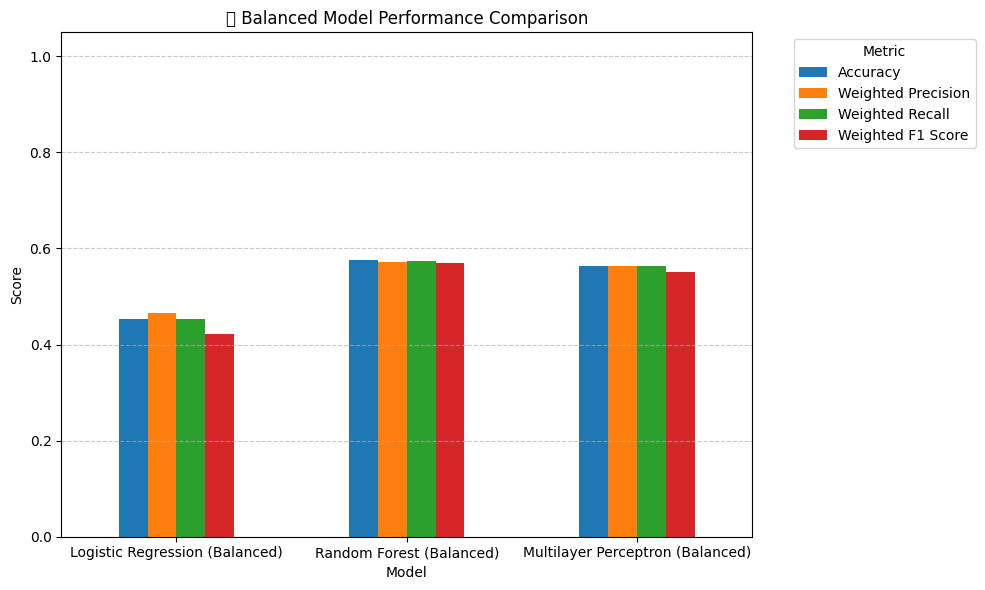

In [0]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics_to_plot = [
    "Accuracy",
    "Weighted Precision",
    "Weighted Recall",
    "Weighted F1 Score"
]

# Select columns
plot_df = balanced_comparison_df[metrics_to_plot]

# Define blue color palette (one for each metric)
shades_of_blue = ['#add8e6', '#87ceeb', '#4682b4', '#1e90ff']  # Light to dark blues

# Plot
ax = plot_df.plot(kind="bar", figsize=(10, 6), rot=0, color=shades_of_blue)

# Style
plt.title("📊 Balanced Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
